# Training DETR using Pytorch

Inspired from  https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb
<br> https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-huggingface-detr-on-custom-dataset.ipynb?ref=blog.roboflow.com#scrollTo=ea3rMbjMN8kl
<br>
<br>
https://huggingface.co/docs/transformers/v4.42.0/en/model_doc/detr#detr

## Importations

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os
import json
import torch
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from transformers import DetrImageProcessor, DetrForObjectDetection
from pycocotools.coco import COCO
from PIL import Image


from utils import init_notebook
%aimport datasets, datasets.cocodetr, datasets.data_visualization
%aimport models.detr.detr
from datasets import cocodetr,data_visualization
from models.detr.detr import Detr


from pathlib import Path

HOME = Path(os.getcwd()).parents[0]
HOME


WindowsPath('c:/Users/Geomatique/Documents/map-symbols-detection-in-historical-maps/notebooks/Sutty_pipeline')

## Prepare the Dataset

### Create Pytorch dataset & dataloader

In [3]:
# Step 1: Load the annotations
annotations_file = (HOME).as_posix()+"/data/coco_datasets/Cocass_aug/ffull_detailed.json"
images_folder = (HOME).as_posix()+"/data/coco_datasets/Cocass_aug/images"

# Instanciate the datas

In [6]:
from datasets.cocodetr import create_coco_pth_datasets
train_ann_name = "ffull_detailed_train.json"
val_ann_name = "fraw_detailed_val.json"
train_dataset, val_dataset = create_coco_pth_datasets(annotations_file, images_folder,
                                                      splitted=True, #Takes a dataset already splitted, if not, split it with a given test size
                                                      train_ann_name=train_ann_name,val_ann_name=val_ann_name)

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [5]:
print(type(train_dataset), type(val_dataset))   # To check if the datasets are in the good type

<class 'datasets.cocodetr.CocoDetection'> <class 'datasets.cocodetr.CocoDetection'>


##### Inspecter le Dataset

Image #1917
Annotations


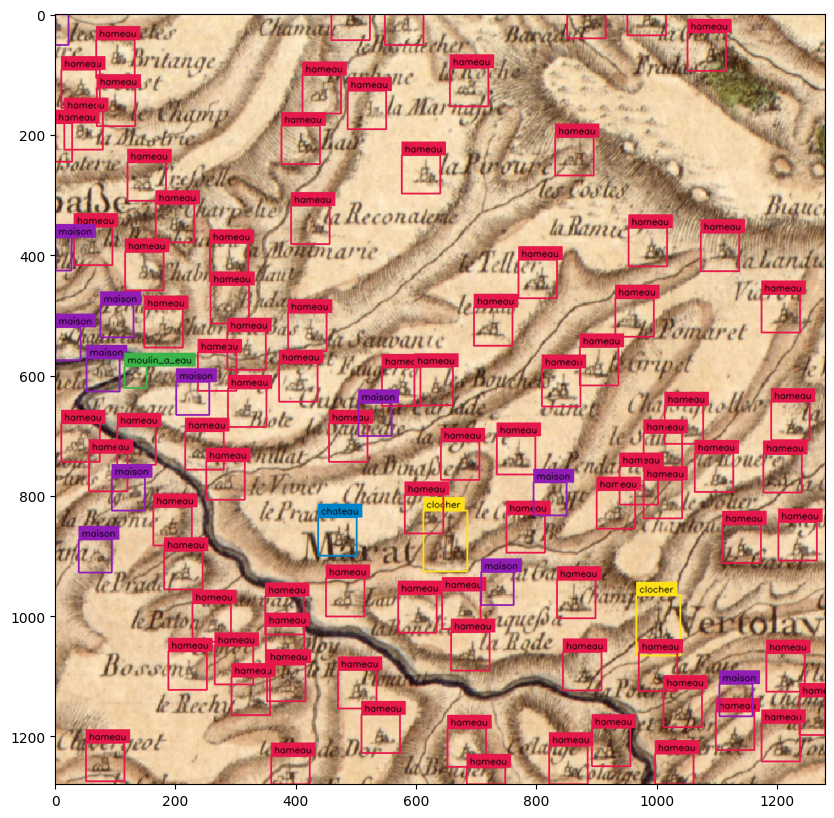

In [6]:
from datasets.data_visualization import pth_dataset_visualize

pth_dataset_visualize(val_dataset, 5)   # To visualize the dataset
# useful to know if there is nothing wrong wit the displayong of the classes and the bounding boxes

In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 5654
Number of validation examples: 5654


#### Dataloader
Called during training to make the link between the pythorch dataset and the train function. Defines here the batches.

In [5]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible 
    # to directly batch together images. Hence they pad the images to the biggest 
    # resolution in a given batch, and create a corresponding binary pixel_mask 
    # which indicates which pixels are real/which are padding
    CHECKPOINT = 'facebook/detr-resnet-101'
    processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True) # We shuffle the training set for the model not to take into account order of the images
VAL_DATALOADER = DataLoader(dataset=val_dataset, collate_fn=collate_fn, batch_size=4, shuffle=False)
# It is unecessary to shuffle the validation set because the calculation of the loss for validation is linear and the order of the images does not matter

#####   Dataloader inspection

In [30]:
batch = next(iter(TRAIN_DATALOADER))    

In [31]:
batch.keys()    

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [32]:
pixel_values, target = train_dataset[0]

In [33]:
pixel_values.shape  #Check if the tensor shape is right. DETR remap in 800x800 but keeps in memory the original size of the image

torch.Size([3, 800, 800])

In [34]:
print(target)

{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]), 'boxes': tensor([[0.0325, 0.3307, 0.0650, 0.1167],
        [0.1864, 0.4976, 0.1167, 0.1167],
        [0.3218, 0.5427, 0.1167, 0.1167],
        [0.3960, 0.1880, 0.1167, 0.1167],
        [0.4057, 0.6706, 0.1167, 0.1167],
        [0.4432, 0.0394, 0.1167, 0.0789],
        [0.5037, 0.7552, 0.1167, 0.1167],
        [0.5649, 0.0466, 0.1167, 0.0932],
        [0.5935, 0.1619, 0.1167, 0.1167],
        [0.6204, 0.6347, 0.1167, 0.1167],
        [0.6490, 0.9324, 0.1167, 0.1167],
        [0.8075, 0.1995, 0.1167, 0.1167],
        [0.8514, 0.8535, 0.1167, 0.1167],
        [0.8932, 0.8087, 0.1167, 0.1167],
        [0.1138, 0.4182, 0.0667, 0.0667],
        [0.7994, 0.4016, 0.0667, 0.0667],
        [0.8862, 0.0481, 0.0667, 0.0667]]), 'area': tensor([4853.1001, 8711.1113, 8711.1113, 8711.1113, 8711.1113, 5888.0029,
        8711.1113, 6960.6401, 8711.1113, 8711.1113, 8711.1113,

## Train the Model using Pytorch Lightning

Importation d'un modèle préentrainé

In [6]:
# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-101'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)    # Load the processor to read the images
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)   # Load the base model
model.to(DEVICE)    # Send the model to the device

Some weights of the model checkpoint at facebook/detr-resnet-101 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

Model initialization

In [7]:
num_labels = len(train_dataset.coco.cats)   # Important for the model to know how many classes it has to predict
model = Detr(CHECKPOINT,num_labels, TRAIN_DATALOADER, VAL_DATALOADER,
             lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

# batch = next(iter(TRAIN_DATALOADER))
# outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-101 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoi

: 

Training

In [ ]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 75

# pytorch_lightning < 2.0.0
# trainer = Trainer(gpus=1, max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

# pytorch_lightning >= 2.0.0
trainer = Trainer(devices=1, 
                  accelerator="gpu", 
                  max_epochs=MAX_EPOCHS, 
                  gradient_clip_val=0.1, 
                  accumulate_grad_batches=8, 
                  log_every_n_steps=2,
                  default_root_dir=HOME/"runs/detr")    # Save the logs in the runs/detr folder

trainer.fit(model)

#### Observe logs on Tensorboard

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir ../runs/detr/lightning_logs/ --port 2348

## Save the model

In [86]:
save_dir = HOME/"outputs/detr/detr_v4"

model.model.save_pretrained(save_dir)
#model.save_model(save_dir)

In [87]:
# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.7

model_path=HOME/"outputs/detr/detr_v4"

CHECKPOINT = 'facebook/detr-resnet-101'

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model=DetrForObjectDetection.from_pretrained(model_path)    # load the model from the checkpoint as a DEtrForObjectDetection model pretrained by the weights of the model_path
#model = Detr(model)
model.to(DEVICE)

08/05/2024 14:24:18 - INFO - timm.models._builder -   Loading pretrained weights from Hugging Face hub (timm/resnet101.a1h_in1k)
08/05/2024 14:24:18 - INFO - timm.models._hub -   [timm/resnet101.a1h_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
08/05/2024 14:24:18 - INFO - timm.models._builder -   Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

## Inférences et evaluations du modèle

### Comparing `Ground Truth` and `Prediction`

Image #497
Ground Truth and Predictions


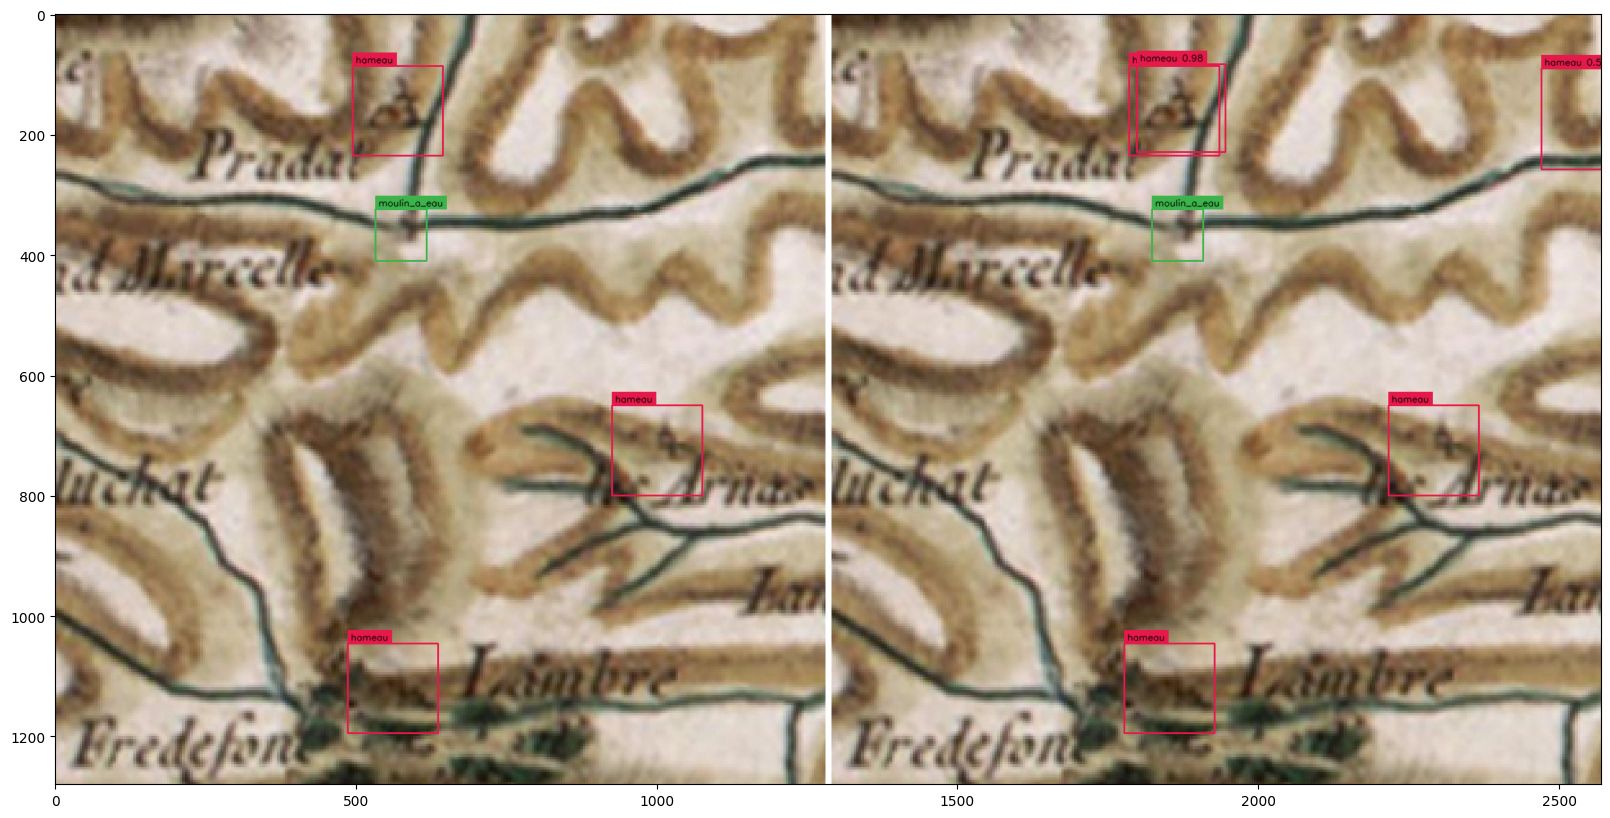

Image #390
Ground Truth and Predictions


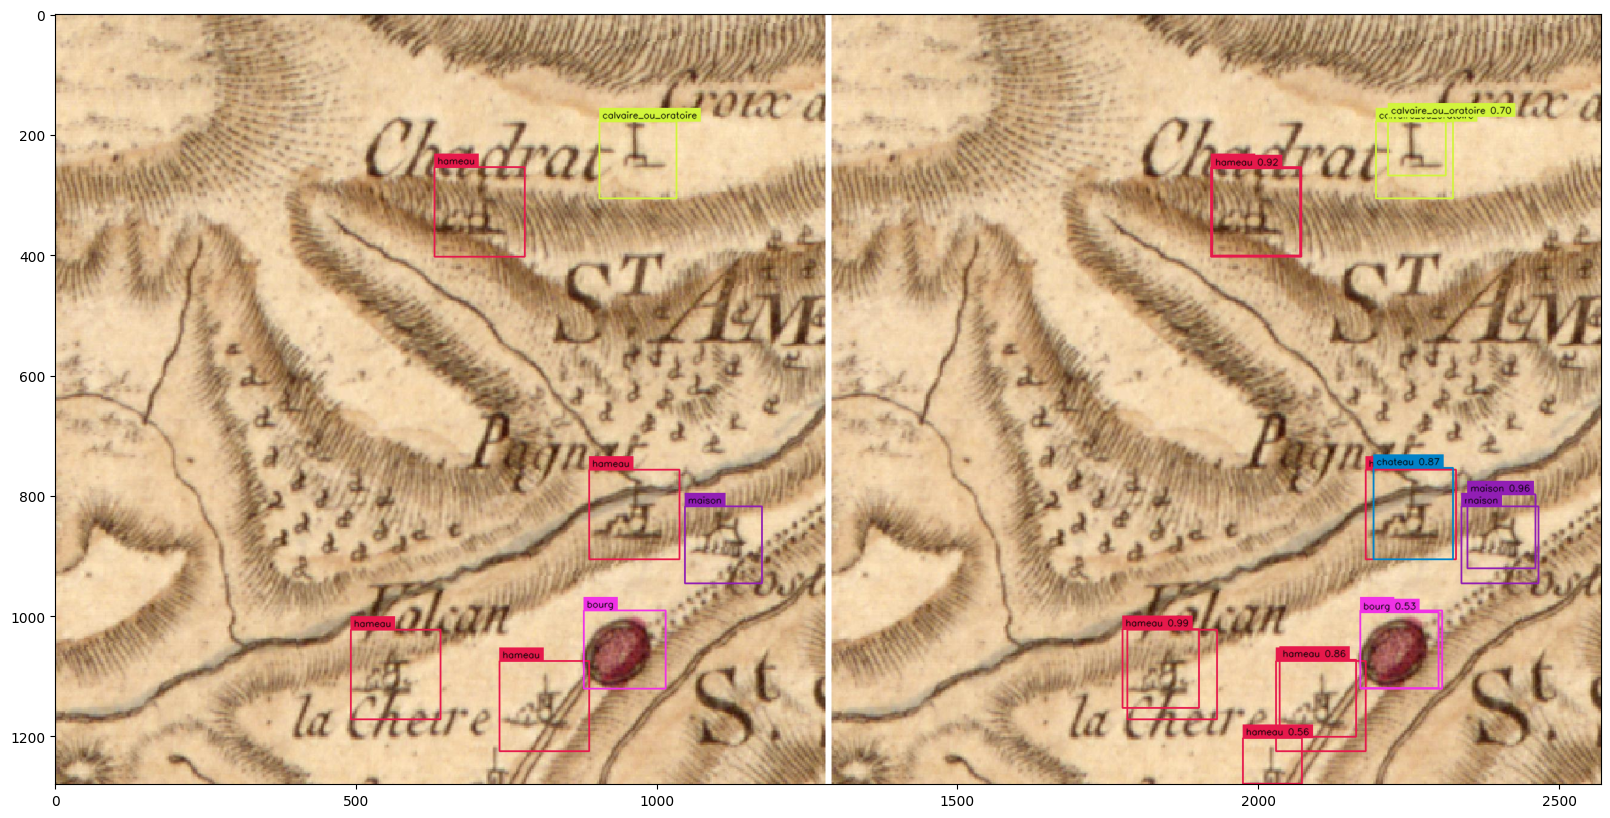

Image #1885
Ground Truth and Predictions


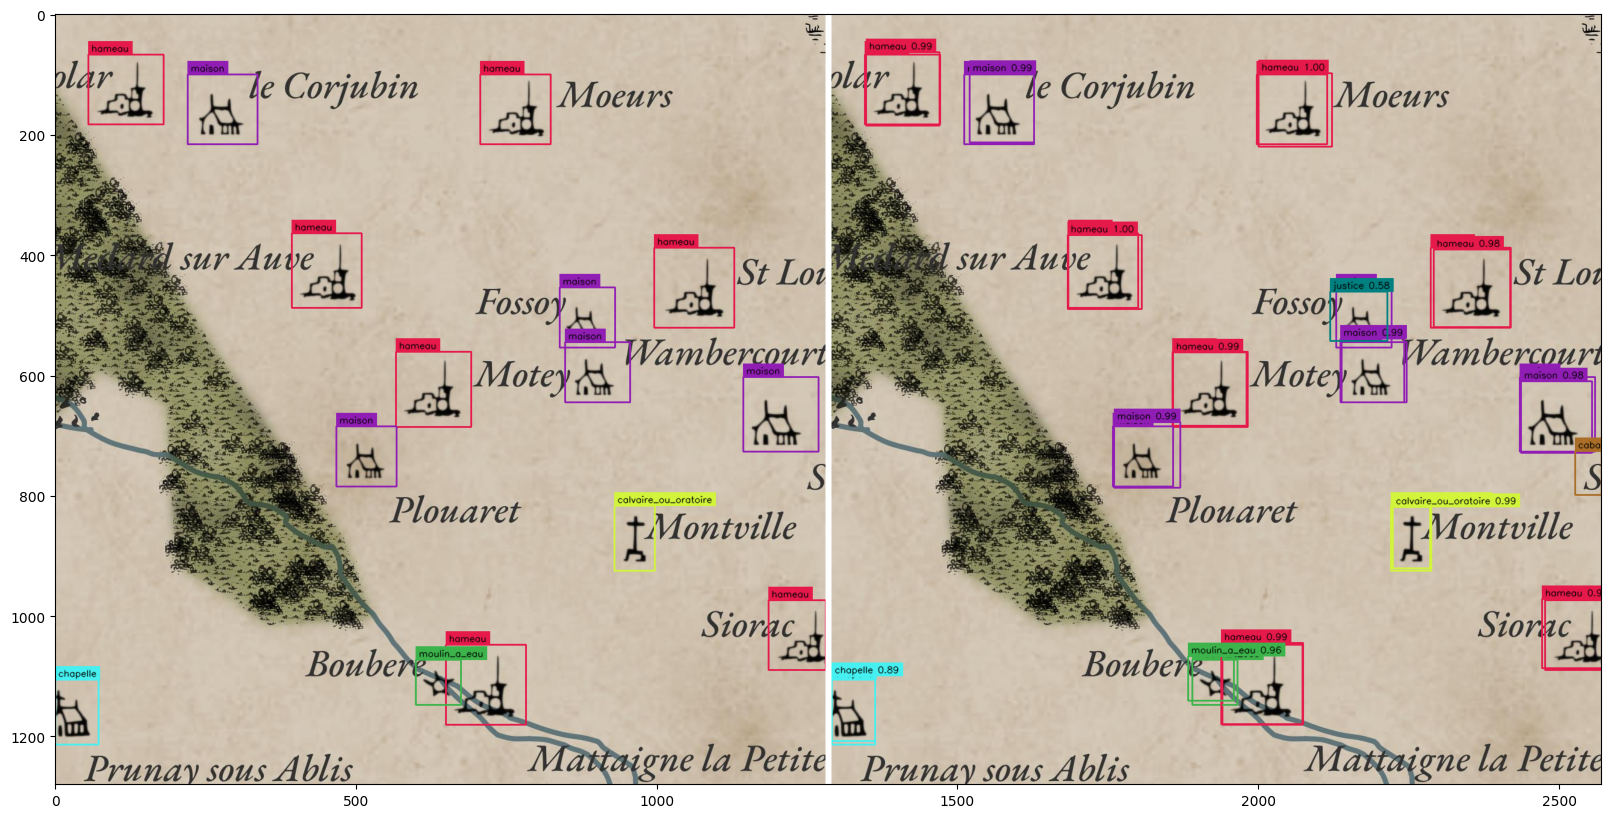

In [91]:
from datasets.data_visualization import pth_dataset_visualize

pth_dataset_visualize(train_dataset, 3,
                      val=True,plot_over=False, #If plot over you have both bounding boxes on the image
                      model=model,processor=image_processor,CONFIDENCE_TRESHOLD=CONFIDENCE_TRESHOLD)